In [59]:
import os
from dotenv import load_dotenv

load_dotenv()

from datasets import load_dataset

ds = load_dataset("UTAustin-AIHealth/MedHallu", "pqa_labeled")

In [60]:
import goodfire
GOODFIRE_API_KEY = os.getenv("GOODFIRE_API_KEY")
client = goodfire.Client(api_key=GOODFIRE_API_KEY)
variant = goodfire.Variant("meta-llama/Meta-Llama-3.1-8B-Instruct")

In [61]:
df = ds['train'].to_pandas()
shuffled_df = df.sample(frac=1, random_state=42)

In [62]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(shuffled_df, test_size=0.3, random_state=42)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")

Training set size: 700, Test set size: 300


In [63]:
FEATURE_COMPUTE_SIZE = 60

In [64]:
non_hallucinated_features, hallucinated_features = client.features.contrast(
    dataset_1=[
        [
            {
                "role": "user",
                "content": f"Here is some relevant knowledge: {row['Knowledge']}\n\nQuestion: {row['Question']}",
            },
            {"role": "assistant", "content": row['Ground Truth']},
        ]
        for _,row in train_df[0:FEATURE_COMPUTE_SIZE].iterrows()
    ],
    dataset_2=[
        [
            {
                "role": "user",
                "content": f"Here is some relevant knowledge: {row['Knowledge']}\n\nQuestion: {row['Question']}",
            },
            {
                "role": "assistant", 
                "content": f"{row['Hallucinated Answer']}]" 
            }
        ]
        for _,row in train_df[0:FEATURE_COMPUTE_SIZE].iterrows()
    ],
    model=variant,
    top_k=100,
)

In [65]:
hallucination_query = "medical misinformation and factual errors in healthcare answers"
non_hallucination_query = "accurate and factual medical information with proper evidence"


non_hallucinated_features = client.features.rerank(
    features=non_hallucinated_features,
    query=non_hallucination_query,
    model=variant,
    top_k=50
)
hallucinated_features = client.features.rerank(
    features=hallucinated_features,
    query=hallucination_query,
    model=variant,
    top_k=50
)

In [66]:
features_to_use_for_classification = non_hallucinated_features | hallucinated_features

In [71]:
features_to_use_for_classification

FeatureGroup([
   0: "Academic or technical results and findings being presented",
   1: "The assistant should provide careful qualifications and disclaimers",
   2: "Scientific methodology and analytical terminology",
   3: "Evidence-based implementation and evaluation strategies",
   4: "Scientific uncertainty and calls for more research",
   5: "Periods separating distinct observations in clinical/technical reports",
   6: "Technical documentation explaining protocols and procedures",
   7: "Chemical and technical term morphemes across languages",
   8: "The assistant expressing need for more research to validate preliminary findings",
   ...
   99: "Legal and procedural language describing official requirements"
])

In [67]:
row = train_df.iloc[0]

In [68]:
inspector = client.features.inspect(
                    [
                        {
                            "role": "user",
                            "content": f"Here is some relevant knowledge: {row['Knowledge']}\n\nQuestion: {row['Question']}",
                        },
                        {"role": "assistant", "content": row['Ground Truth'] }#if is_positive_class else f"{row['Hallucinated Answer']}]"

                    ],
                    model=variant,
                    features=features_to_use_for_classification,
                )

In [69]:
[{
                            "role": "user",
                            "content": f"Here is some relevant knowledge: {row['Knowledge']}\n\nQuestion: {row['Question']}",
                        },
                        {"role": "assistant", "content": row['Ground Truth'] }
                        ]


[{'role': 'user',
  'content': "Here is some relevant knowledge: ['Cerebral hemispherectomy, a surgical procedure undergone to control intractable seizures, is becoming a standard procedure with more cases identified and treated early in life [33]. While the effect of the dominant hemisphere resection on spoken language has been extensively researched, little is known about reading abilities in individuals after left-sided resection. Left-lateralized phonological abilities are the key components of reading, i.e., grapheme-phoneme conversion skills [1]. These skills are critical for the acquisition of word-specific orthographic knowledge and have been shown to predict reading levels in average readers as well as in readers with mild cognitive disability [26]. Furthermore, impaired phonological processing has been implicated as the cognitive basis in struggling readers. Here, we explored the reading skills in participants who have undergone left cerebral hemispherectomy.'\n 'Seven indivi

In [70]:
# Analyze how features activate in text
inspector_hallucinated = client.features.inspect(
    [
       {
                            "role": "user",
                            "content": f"Here is some relevant knowledge: {row['Knowledge']}\n\nQuestion: {row['Question']}",
                        },
                        {"role": "assistant", "content": row['Hallucinated Answer'] }

    ],
    model=variant,
                    features=features_to_use_for_classification,
)

# Get top activated features
for activation in inspector_hallucinated.top(k=25):
    print(f"{activation.feature.label}: {activation.activation}")

Study population descriptions in scientific papers: 81
Numerical statistical results reporting with significance levels: 63
Statistical result reporting patterns in academic writing: 61
Surgical procedures and operations in clinical contexts: 60
Discussion of potential risks, threats and negative consequences: 55
Legal and procedural language describing official requirements: 55
Numbers appearing in sequential or structured formats: 51
Technical discussion of test measurement properties and assessment methodology: 44
Transitioning into explaining results or findings: 44
Introduction phrases that establish educational or instructional content: 43
The user is asking for a technical or scientific explanation: 34
Formal presentation of research findings and study results: 29
Scientific explanations of mechanisms and processes: 28
Medical diagnostic relationships between diseases and symptoms: 26
Academic research methodology descriptions: 21
Medical terminology for anatomical locations and

In [53]:
# Analyze how features activate in text
inspector = client.features.inspect(
    [
       {
                            "role": "user",
                            "content": f"Here is some relevant knowledge: {row['Knowledge']}\n\nQuestion: {row['Question']}",
                        },
                        {"role": "assistant", "content": row['Ground Truth'] }#if is_positive_class else f"{row['Hallucinated Answer']}]"

    ],
    model=variant,
                    features=features_to_use_for_classification,
)

# Get top activated features
for activation in inspector.top(k=25):
    print(f"{activation.feature.label}: {activation.activation}")

Study population descriptions in scientific papers: 90
Surgical procedures and operations in clinical contexts: 74
Numerical statistical results reporting with significance levels: 72
Statistical result reporting patterns in academic writing: 63
Discussion of potential risks, threats and negative consequences: 57
Legal and procedural language describing official requirements: 55
Numbers appearing in sequential or structured formats: 51
Technical discussion of test measurement properties and assessment methodology: 46
Introduction phrases that establish educational or instructional content: 43
Transitioning into explaining results or findings: 42
The user is asking for a technical or scientific explanation: 38
Formal presentation of research findings and study results: 32
Scientific explanations of mechanisms and processes: 31
Medical diagnostic relationships between diseases and symptoms: 30
Content that should be rejected or flagged as problematic: 23
Scientific methodology and analyt

In [40]:
# ... existing code ...

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def heatmap_plot(inspector):
    feature_labels = []
    activation_values = []

    for activation in inspector.top(k=10):
        feature_labels.append(activation.feature.label)
        activation_values.append(activation.activation)

    # Create a DataFrame for easier plotting
    activation_df = pd.DataFrame({
        'Feature': feature_labels,
        'Activation': activation_values
    })

    # Sort by activation strength for better visualization
    activation_df = activation_df.sort_values('Activation', ascending=False).reset_index(drop=True)

    
    """
    # Create a heatmap
    plt.figure(figsize=(6, 7))
    # Reshape data for heatmap (1 row, multiple columns)
    heatmap_data = activation_df['Activation'].values.reshape(1, -1)

    # Create the heatmap
    ax = sns.heatmap(heatmap_data, 
                    cmap='viridis',
                    annot=True, 
                    fmt='.1f',
                    cbar_kws={'label': 'Activation Strength'})

    # Set y-axis label to empty (since we have only one row)
    ax.set_yticks([])
    
    # Position x-axis labels vertically for readability
    plt.xticks(np.arange(len(feature_labels)) + 0.5, activation_df['Feature'], rotation=90, ha='center')

    plt.title('Feature Activation Strengths', fontsize=16)
    plt.tight_layout()
    plt.show()
    """
    # Alternative: Horizontal bar chart (often more readable for many features)
    plt.figure(figsize=(6, 7))
    sns.barplot(x='Activation', y='Feature', data=activation_df, palette='viridis')
    plt.title('Feature Activation Strengths', fontsize=16)
    plt.xlabel('Activation Strength')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2967430/2363730897.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Activation', y='Feature', data=activation_df, palette='viridis')
/tmp/ipykernel_2967430/2363730897.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


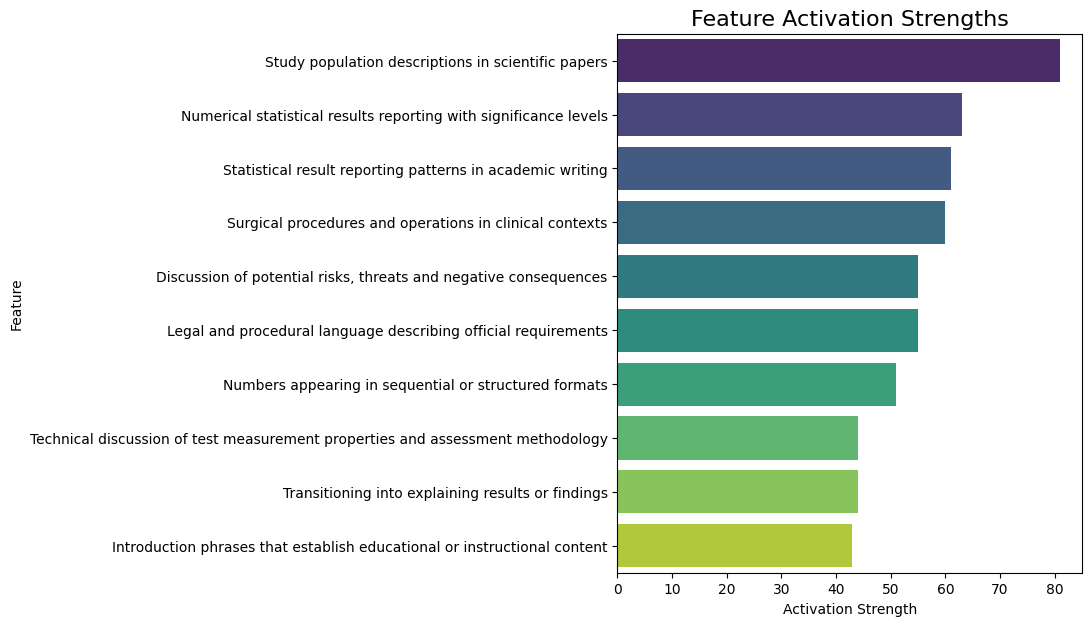

In [41]:
heatmap_plot(inspector_hallucinated)

In [56]:
def compare_activations(inspector1, inspector2, k=20, title1="Hallucinated", title2="Ground Truth"):
    # Extract feature activations for both inspectors
    features1 = {}
    features2 = {}
    
    # Get top k activations from both inspectors
    for activation in inspector1.top(k=k):
        features1[activation.feature.label] = activation.activation
    
    for activation in inspector2.top(k=k):
        features2[activation.feature.label] = activation.activation
    
    # Combine all unique features
    all_features = set(list(features1.keys()) + list(features2.keys()))
    
    # Create a DataFrame with all features and their activations
    comparison_df = pd.DataFrame({
        'Feature': list(all_features),
        f'{title1} Activation': [features1.get(feature, 0) for feature in all_features],
        f'{title2} Activation': [features2.get(feature, 0) for feature in all_features]
    })
    
    # Calculate the difference in activation
    comparison_df['Activation Difference'] = comparison_df[f'{title1} Activation'] - comparison_df[f'{title2} Activation']
    
    # Sort by absolute difference for better visualization
    comparison_df = comparison_df.sort_values('Activation Difference', key=abs, ascending=False).reset_index(drop=True)
    
    
    # Add annotations for clarity
    plt.text(comparison_df['Activation Difference'].min() * 0.9, 1, f'Higher in {title2}', 
             color='#2ca02c', fontweight='bold', ha='center')
    plt.text(comparison_df['Activation Difference'].max() * 0.9, 1, f'Higher in {title1}', 
             color='#d62728', fontweight='bold', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Create a heatmap for side-by-side comparison
    plt.figure(figsize=(16, 12))
    
    # Prepare data for heatmap
    heatmap_df = comparison_df[['Feature', f'{title1} Activation', f'{title2} Activation']]
    heatmap_data = heatmap_df.set_index('Feature').T
    
    # Create the heatmap
    sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.1f', 
                cbar_kws={'label': 'Activation Strength'})
    
    plt.title(f'Feature Activation Comparison: {title1} vs {title2}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Create a scatter plot to show correlation
    plt.figure(figsize=(10, 10))
    plt.scatter(comparison_df[f'{title1} Activation'], 
                comparison_df[f'{title2} Activation'], 
                alpha=0.7, s=100)
    
    # Add feature labels to points
    for i, feature in enumerate(comparison_df['Feature']):
        plt.annotate(feature, 
                    (comparison_df[f'{title1} Activation'].iloc[i], 
                     comparison_df[f'{title2} Activation'].iloc[i]),
                    fontsize=8, alpha=0.8)
    
    # Add diagonal line (y=x)
    max_val = max(comparison_df[f'{title1} Activation'].max(), comparison_df[f'{title2} Activation'].max())
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
    
    plt.xlabel(f'{title1} Activation', fontsize=12)
    plt.ylabel(f'{title2} Activation', fontsize=12)
    plt.title(f'Feature Activation Scatter Plot: {title1} vs {title2}', fontsize=16)

/tmp/ipykernel_2967430/1913895141.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


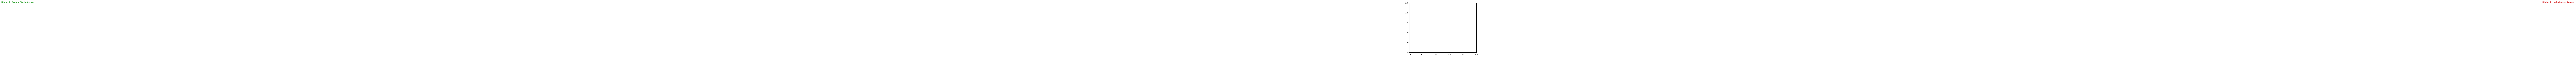

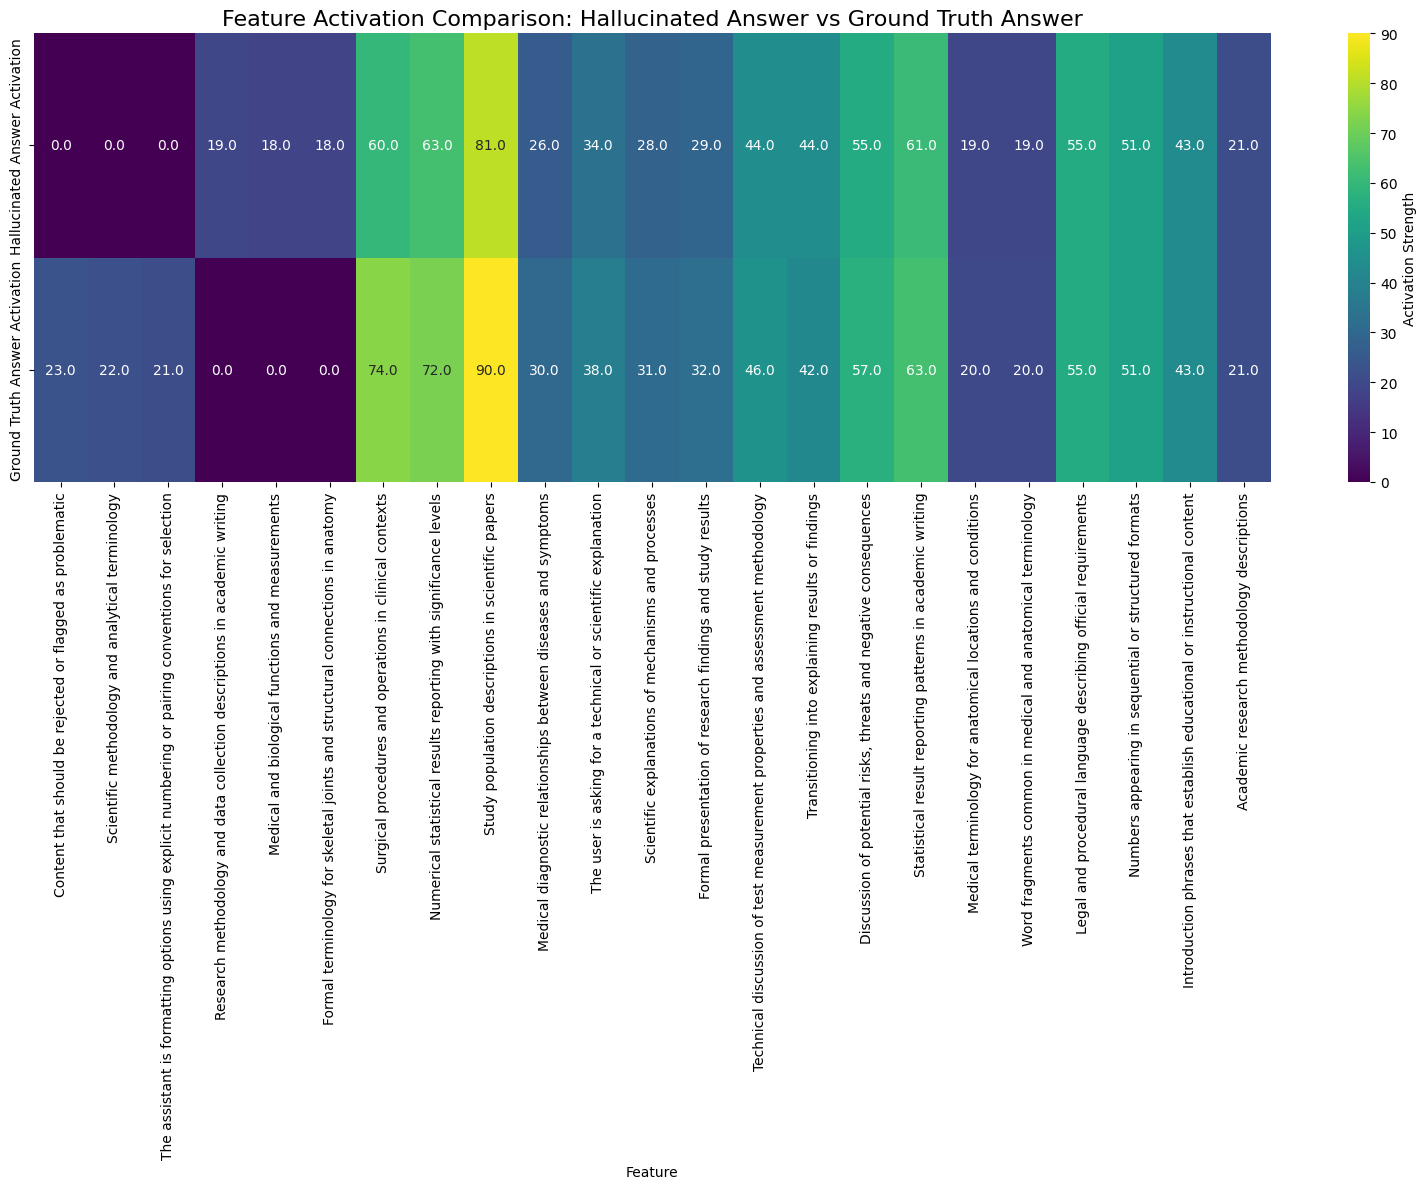

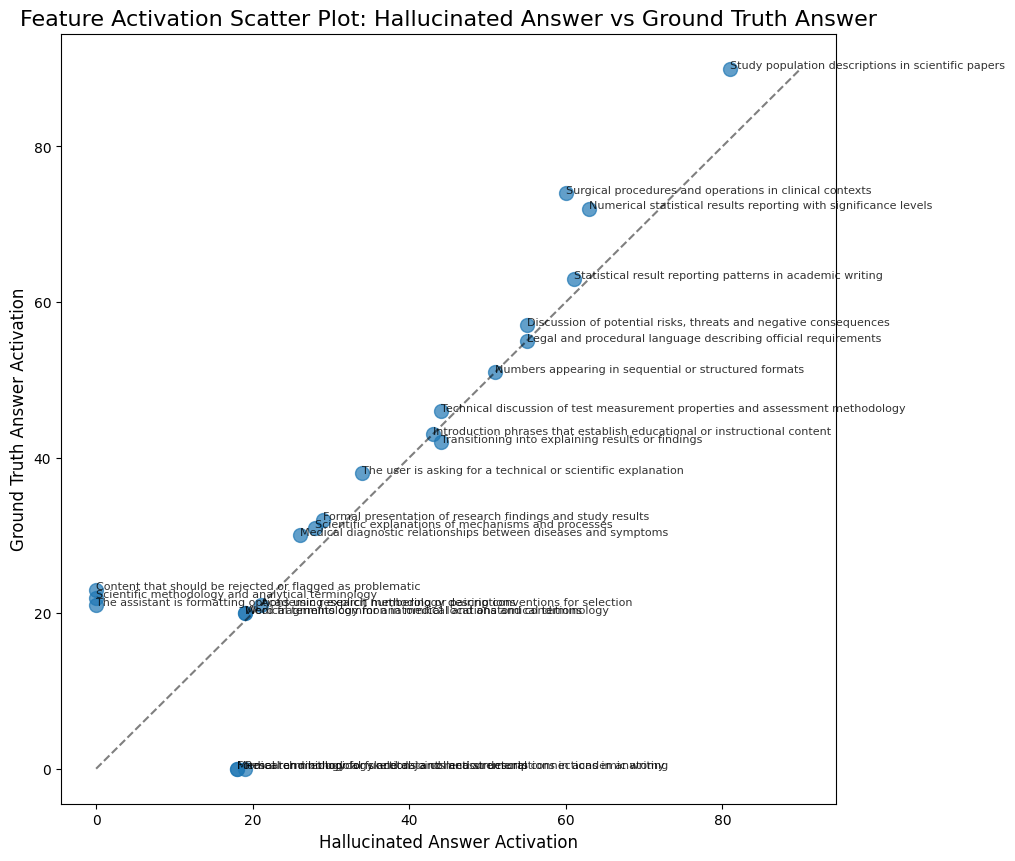

In [57]:
compare_activations(inspector_hallucinated, inspector, 
                   title1="Hallucinated Answer", 
                   title2="Ground Truth Answer")